In [1]:
import os
import sys
sys.path = ['efficientnet-b0-08094119.pth'] + sys.path

import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm 
#import enet_model
#import enet_utils 
import warnings
warnings.filterwarnings("ignore") 

In [2]:
df_train = pd.read_csv('train.csv')
image_folder = os.path.join('train_images')

kernel_type = 'how_to_train_effnet_b0_to_get_LB_0.86'

enet_type = 'efficientnet-b0'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 20
device = torch.device('cuda') 

In [3]:
skf = StratifiedKFold(4, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,3
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,2
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,3


In [4]:
pretrained_model = {'efficientnet-b0': 'efficientnet-b0-08094119.pth'}

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x 

The following tiling function performs these steps: 

1. It finds the values we should pad H and W so that the dimensions are multiple of the size
2. it pads the image with constant values 
3. Reshapes the images into an array 
4. Swaps the order so that the dims would be in the right order and reshapes in order to have  a shape like this: numb x (numb x numb x numb) 
5. If the image has less than N tiles it gets padded to fit 
6. It Reshapes, it sums along the row so to get the tiles with the lowest sum, it orders them in ascending order and returns the index of the N smallest values. Then it selects those tiles which are the ones with more tissue regions, cause at a lower sum corresponds more tissue, and finally it lists them 

In [5]:
from PIL import Image 

In [6]:
def get_tiles(img):
        tiles = []
        H, W, C = img.shape
        #1
        pad_H = (tile_size - H % tile_size) % tile_size 
        pad_W = (tile_size - W % tile_size) % tile_size 
        #2
        img2 = np.pad(img,[[pad_H // 2, pad_H - pad_H // 2], [pad_W // 2,pad_W - pad_W//2], 
                            [0,0]], constant_values=255)
        
        #3
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3)
        #4
        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        #5
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        #6
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            tiles.append({'img':img3[i], 'idx':i})
        return tiles, n_tiles_with_info >= n_tiles  

In [7]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [8]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

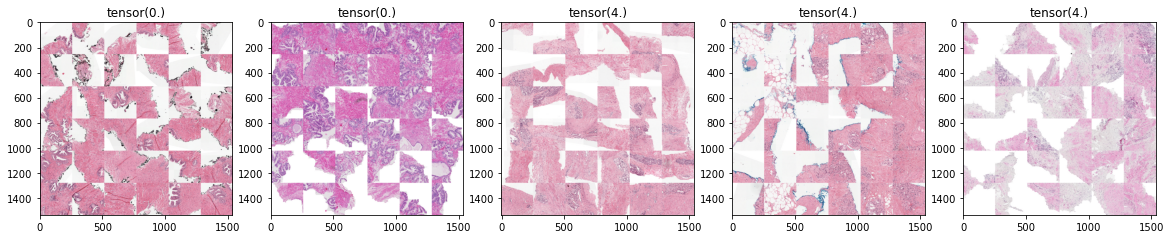

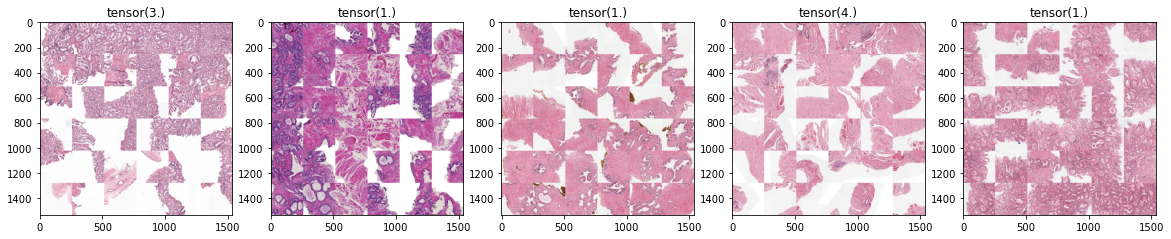

In [9]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [10]:
criterion = nn.BCEWithLogitsLoss() 

In [11]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return PREDS
    else:
        return val_loss, acc, qwk

In [12]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid)) 

7962 2654


In [ ]:
qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)

    if qwk > qwk_max:
        print('score progress: ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Mon Sep 21 18:16:25 2020 Epoch: 1



qwk 0.6981246423233347 qwk_k 0.6919169640991553 qwk_r 0.6090589864868623
Mon Sep 21 19:06:35 2020 Epoch 1, lr: 0.0000300, train loss: 0.44949, val loss: 0.34832, acc: 41.93670, qwk: 0.69812
score progress: (0.000000 --> 0.698125).  Saving model ...
Mon Sep 21 19:06:35 2020 Epoch: 2



qwk 0.7098513014840373 qwk_k 0.6989943809030646 qwk_r 0.6598044473827933
Mon Sep 21 19:56:46 2020 Epoch 2, lr: 0.0003000, train loss: 0.37674, val loss: 0.36429, acc: 53.54182, qwk: 0.70985
score progress: (0.698125 --> 0.709851).  Saving model ...
Mon Sep 21 19:56:46 2020 Epoch: 3



qwk 0.8172208978444839 qwk_k 0.8341041769927924 qwk_r 0.7539477963260217
Mon Sep 21 20:46:58 2020 Epoch 3, lr: 0.0000300, train loss: 0.27907, val loss: 0.25822, acc: 53.54182, qwk: 0.81722
score progress: (0.709851 --> 0.817221).  Saving model ...
Mon Sep 21 20:46:59 2020 Epoch: 4



qwk 0.7058595492190096 qwk_k 0.7016351356910486 qwk_r 0.634815356926353
Mon Sep 21 21:37:27 2020 Epoch 4, lr: 0.0002919, train loss: 0.30549, val loss: 0.34189, acc: 51.88395, qwk: 0.70586
Mon Sep 21 21:37:27 2020 Epoch: 5



qwk 0.7949301843589412 qwk_k 0.8057513773647653 qwk_r 0.7371440668995448
Mon Sep 21 22:27:47 2020 Epoch 5, lr: 0.0002819, train loss: 0.28046, val loss: 0.31460, acc: 58.89224, qwk: 0.79493
Mon Sep 21 22:27:47 2020 Epoch: 6



qwk 0.8346887492405385 qwk_k 0.865320291673698 qwk_r 0.7540658367164278
Mon Sep 21 23:18:13 2020 Epoch 6, lr: 0.0002684, train loss: 0.26336, val loss: 0.26830, acc: 53.84326, qwk: 0.83469
score progress: (0.817221 --> 0.834689).  Saving model ...
Mon Sep 21 23:18:13 2020 Epoch: 7



qwk 0.8428849717504807 qwk_k 0.8562092801011075 qwk_r 0.7878931659465679
Tue Sep 22 00:08:27 2020 Epoch 7, lr: 0.0002516, train loss: 0.25143, val loss: 0.24733, acc: 59.75885, qwk: 0.84288
score progress: (0.834689 --> 0.842885).  Saving model ...
Tue Sep 22 00:08:27 2020 Epoch: 8



qwk 0.8359428366612781 qwk_k 0.8470612840783331 qwk_r 0.7830937093803745
Tue Sep 22 00:58:42 2020 Epoch 8, lr: 0.0002320, train loss: 0.24041, val loss: 0.32131, acc: 54.52148, qwk: 0.83594
Tue Sep 22 00:58:42 2020 Epoch: 9



qwk 0.8123174368808946 qwk_k 0.8313693614792814 qwk_r 0.7600860155338043
Tue Sep 22 01:48:59 2020 Epoch 9, lr: 0.0002103, train loss: 0.22663, val loss: 0.28722, acc: 62.28335, qwk: 0.81232
Tue Sep 22 01:48:59 2020 Epoch: 10



qwk 0.8527541248705673 qwk_k 0.8760422788457382 qwk_r 0.7951384688647332
Tue Sep 22 02:39:08 2020 Epoch 10, lr: 0.0001868, train loss: 0.21346, val loss: 0.27703, acc: 60.43708, qwk: 0.85275
score progress: (0.842885 --> 0.852754).  Saving model ...
Tue Sep 22 02:39:08 2020 Epoch: 11



qwk 0.8434345581148855 qwk_k 0.8694898495801429 qwk_r 0.7780757014080815
Tue Sep 22 03:29:23 2020 Epoch 11, lr: 0.0001624, train loss: 0.20924, val loss: 0.25566, acc: 59.26903, qwk: 0.84343
Tue Sep 22 03:29:23 2020 Epoch: 12



qwk 0.8546829585980188 qwk_k 0.8756151318037643 qwk_r 0.8022609141459079
Tue Sep 22 04:19:37 2020 Epoch 12, lr: 0.0001376, train loss: 0.19566, val loss: 0.23972, acc: 63.45139, qwk: 0.85468
score progress: (0.852754 --> 0.854683).  Saving model ...
Tue Sep 22 04:19:37 2020 Epoch: 13



qwk 0.8607162956084979 qwk_k 0.8828397551684176 qwk_r 0.8049136467951816
Tue Sep 22 05:09:46 2020 Epoch 13, lr: 0.0001132, train loss: 0.18711, val loss: 0.24038, acc: 64.58176, qwk: 0.86072
score progress: (0.854683 --> 0.860716).  Saving model ...
Tue Sep 22 05:09:46 2020 Epoch: 14



qwk 0.8601865951589569 qwk_k 0.8881118488447833 qwk_r 0.7999172062849725
Tue Sep 22 05:59:55 2020 Epoch 14, lr: 0.0000897, train loss: 0.17579, val loss: 0.23813, acc: 62.96157, qwk: 0.86019
Tue Sep 22 05:59:55 2020 Epoch: 15


## Visualizing and understanding the network 
### Forward hooks 

In [ ]:
df_valid  = df_train.loc[780].to_frame().transpose()
#df_valid.astype({'col1': 'int32'}).dtypes
df_valid 

In [ ]:
df_valid['isup_grade'] = df_valid['isup_grade'].astype('int')
df_valid.info()

In [ ]:
sys.path = ['effnet_best_fold.pth'] + sys.path
model_dict = {'efficientnet-b0': 'effnet_best_fold.pth'}
model = enetv2(enet_type, out_dim=out_dim)
model.load_state_dict(torch.load(model_dict['efficientnet-b0']))
model.to(device)
model.eval() 

#df_valid  = df_train.loc[780].to_frame().transpose()
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)
valid_loader = torch.utils.data.DataLoader(dataset_valid, num_workers=num_workers) 
val_epoch(valid_loader, get_output=True) 

In [ ]:
sys.path = ['how_to_train_effnet_b0_to_get_LB_0.86_final_fold0.pth'] + sys.path
model_dict = {'efficientnet-b0': 'how_to_train_effnet_b0_to_get_LB_0.86_final_fold0.pth'}
model = enetv2(enet_type, out_dim=out_dim)
model.load_state_dict(torch.load(model_dict['efficientnet-b0']))
model.eval()

visualisation = {}

def hook_fn(m, i, o):
    visualisation[m] = o 

def get_all_layers(net):
    for name, layer in net._modules.items():
        if isinstance(layer, nn.Sequential):
            get_all_layers(layer)
        else:
            layer.register_forward_hook(hook_fn)

get_all_layers(model)

# Just to check whether we got all layers
visualisation.keys()

def preprocess(transform=transforms_train):
    tiff_file = os.path.join(image_folder, '005e66f06bce9c2e49142536caf2f6ee.tiff')
    image = skimage.io.MultiImage(tiff_file)[1]
    tiles, OK = get_tiles(image)
    
    idxes = list(range(n_tiles))

    n_row_tiles = int(np.sqrt(n_tiles))
    images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
    for h in range(n_row_tiles):
        for w in range(n_row_tiles):
            i = h * n_row_tiles + w
    
            if len(tiles) > idxes[i]:
                this_img = tiles[idxes[i]]['img']
            else:
                this_img = np.ones((image_size, image_size, 3)).astype(np.uint8) * 255
            this_img = 255 - this_img
            if transform is not None:
                this_img = transform(image=this_img)['image']
            h1 = h * image_size
            w1 = w * image_size
            images[h1:h1+image_size, w1:w1+image_size] = this_img

    if transform is not None:
        images = transform(image=images)['image']
    images = images.astype(np.float32)
    images /= 255
    images = images.transpose(2, 0, 1)

    label = np.zeros(5).astype(np.float32)
    label[:row.isup_grade] = 1.
    Tensor = torch.tensor(images) 
    Label= torch.tensor(label)
    return Tensor 

out = model(preprocess()) 

def showTensor(Tensor):
    plt.figure()
    plt.imshow(Tensor.numpy())
    plt.colorbar()
    plt.show() 
    
showTensor(out)  

In [ ]:
import cv2 as cv

model = model 
print(model)
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [ ]:
model_children

In [ ]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2dStaticSamePadding:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2dStaticSamePadding:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

In [ ]:
nn.Conv2dStaticSamePadding

## Image occlusions

In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) 
            #in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap 

In [ ]:
heatmap = occlusion(model, images, pred[0].item(), 32, 14)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure() 

## Saliency maps

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image

model = model
for param in model.parameters():
    param.requires_grad = False 

In [ ]:
def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [ ]:
model.eval()
X.requires_grad_()
scores = model(X)
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]
score_max.backward()
saliency, _ = torch.max(X.grad.data.abs(),dim=1)
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show() 